In [2]:
import pandas as pd
import numpy as np
import nltk
import helpers.data_mining_helpers as dmh
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer # generate document frequency matrix
from sklearn.feature_extraction.text import TfidfVectorizer # generate document TF-IDF matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# visulize
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

## Part1: Take Home Exercises

### **>>> Exercise 2 (take home):** 
Experiment with other querying techniques using pandas dataframes. I get the first five data that category name of X is `soc.religion.christian`. 

In [51]:
# categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
# fentch certain category data
twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42)
# construct dataframe from a list
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])
# add category to the dataframe
X['category'] = twenty_train.target
# add category label also
X['category_name'] = X.category.apply(lambda t: dmh.format_labels(t, twenty_train))
# Answer here
X.loc[X.category_name=='soc.religion.christian'][:5]

,text,category,category_name
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian


### >>> **Exercise 5 (take home)** 
Please check the data and the process below, describe what you observe and why it happened:

If the data type is input as 'Nan' or 'None', it will be treated as a string.  However, if it's input as `np.nan` or `None`, it will be recognized as a missing value. 

In [52]:
NA_dict = [{ 'id': 'A', 'missing_example': np.nan },
           { 'id': 'B'                    },
           { 'id': 'C', 'missing_example': 'NaN'  },
           { 'id': 'D', 'missing_example': 'None' },
           { 'id': 'E', 'missing_example':  None  },
           { 'id': 'F', 'missing_example': ''     }]

NA_df = pd.DataFrame(NA_dict, columns = ['id','missing_example'])
NA_df

,id,missing_example
0,A,NaN
1,B,NaN
2,C,NaN
3,D,None
4,E,None
5,F,


In [53]:
NA_df['missing_example'].isnull()

0     True
1     True
2    False
3    False
4     True
5    False
Name: missing_example, dtype: bool

### >>> Exercise 6 (take home):
Notice any changes from the `X` dataframe to the `X_sample` dataframe? What are they? Report every change you noticed as compared to the previous state of `X`. Feel free to query and look more closely at the dataframe for these changes:

1. The dimensions of X and X_sample are observed to be different. As shown below, dim(X)=(2257, 3) and dim(X_sample)=(1000, 3)
2. Because X_sample is sampled from X, X_sample is a subset of X.

In [54]:
# sample 
X_sample = X.sample(n = 1000) #random state

# Answer here
print(f'dimension of X:{X.shape},', f'dimension of X_shape:{X_sample.shape}') # different dimension

dimension of X:(2257, 3), dimension of X_shape:(1000, 3)


### >>> **Exercise 8 (take home):** 
We can also do a side-by-side comparison of the distribution between the two datasets, but maybe you can try that as an excerise. Below we show you an snapshot of the type of chart we are looking for. 

<Axes: title={'center': 'Category Distribution'}, xlabel='category_name'>

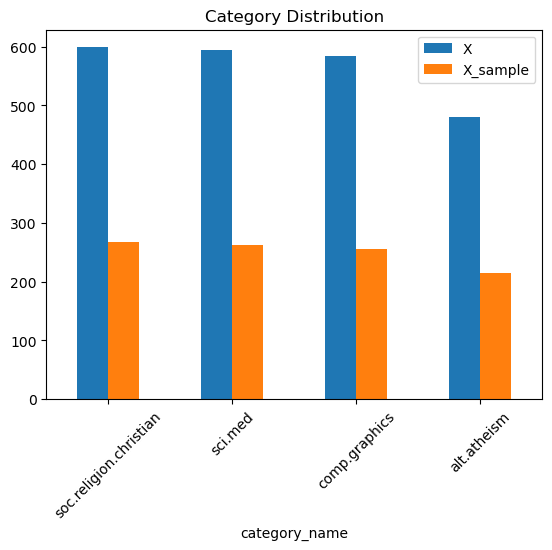

In [55]:
# Answer here:
df_X = pd.DataFrame(X.category_name.value_counts())
df_X.columns = ['X']
df_X_sample = pd.DataFrame(X_sample.category_name.value_counts())
df_X_sample.columns = ['X_sample']
df = pd.concat([df_X, df_X_sample], axis=1)
df.plot.bar(title = 'Category Distribution', rot = 45)

### **>>> Exercise 10 (take home):**
We said that the `1` at the beginning of the fifth record represents the `00` term. Notice that there is another 1 in the same record. Can you provide code that can verify what word this 1 represents from the vocabulary. Try to do this as efficient as possible.

In [57]:
# Answer here
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(f'Another {X_counts[4, 37]} in the same record represents : {count_vect.get_feature_names_out()[37:38]} in the vocabulary')

Another 1 in the same record represents : ['01'] in the vocabulary


---

## Part2: The New Dataset.

### 1. The Data

- The dataset is a collection of Youtube Comments and it was captured using the YouTube Data API.
- The data set consists of 1500 nostalgic and non-nostalgic comments in English.

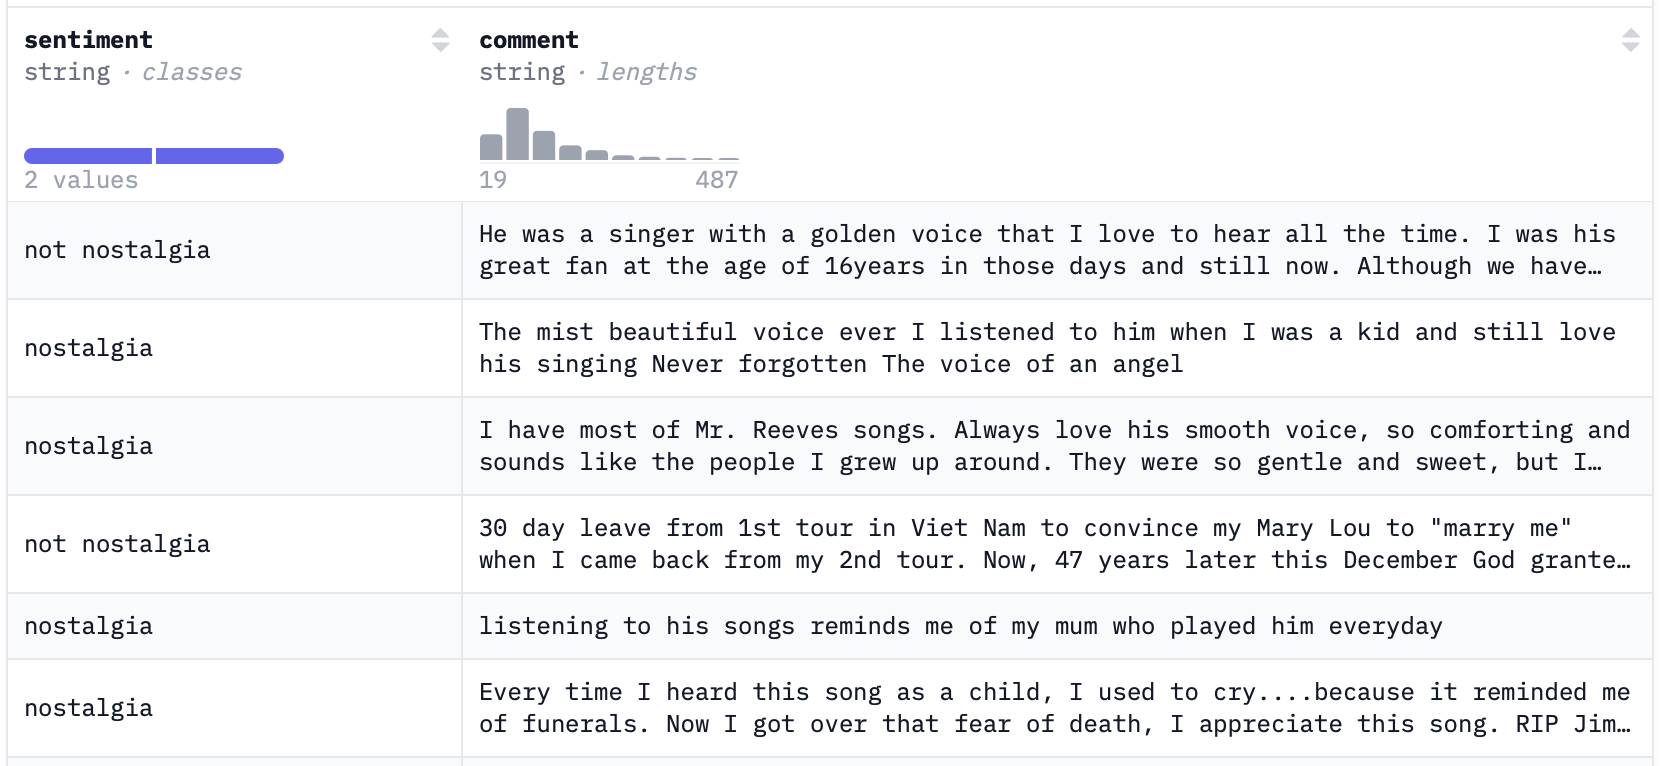

### 2. Data Preparation
I use `pandas` and `fsspec` to read and write remote data throught the Hugging Face paths (hf://) to read and write data on the Hub:

In [19]:
X = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

Let's take a look at some of the records that are contained in our subset of the data.

In [6]:
X.iloc[0:2, :]

,sentiment,comment
0,not nostalgia,He was a singer with a golden voice that I lov...
1,nostalgia,The mist beautiful voice ever I listened to hi...


### 4. Data Mining using Pandas

Check the sum of null records: There is no null record in this record.

In [7]:
print(f'the sum of duplicate records:\n{X.isnull().sum()}')

the sum of duplicate records:
sentiment    0
comment      0
dtype: int64


Check the sum of duplicate records: I find that there is a duplicate record in this dataset, and I delete this record.

In [8]:
# calculate the sum of duplicate datas
print(f'the sum of duplicate records: {X.duplicated().sum()}')
# discard the duplicate row
X.drop_duplicates(keep='first', inplace=True)

the sum of duplicate records: 1


### 5. Data Preprocessing

#### 5.1 Feature Creation
I generate TF-IDF features from the tokens of each text. To prevent high-frequency stop words from skewing subsequent analysis, English stop words were removed before calculating the TF-IDF matrix.

In [40]:
# calculate TF-IDF matrix (remove english stop word)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(X.comment)
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out())
tfidf_df

,00,000,045,07,10,100,10m,11,11th,12,...,youngster,youngsters,youth,youthful,youtube,yrs,yuo,yup,zealand,zulus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5.2 Attribute Transformation / Aggregation

From the attribute aggrrgation, I preliminary analysis the corpus, consider:

- The high frequency of the word "song" is likely due to the YouTube comments being predominantly about videos related to songs.

- Proportion of Nostalgia Keywords:  Count the percentage of keywords explicitly expressing nostalgia (e.g., "memories", "time", "childhood", "old", etc.).  A high proportion, prominently displayed in the word cloud, suggests a strong nostalgic theme.

- Proportion and Distribution of Positive Emotion Words: Observe the proportion and distribution of positive emotion words (e.g., "love", "like", "beautiful", "happy").

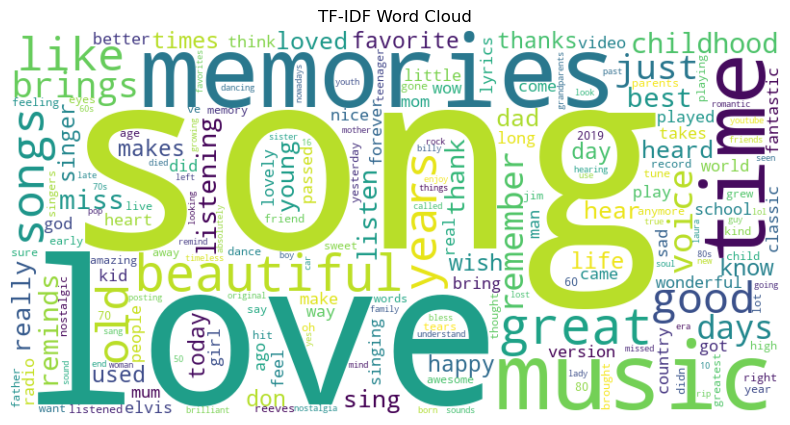

In [46]:
# get tfidf dictionary
tfidf_values = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
tfidf_dict = {vectorizer.get_feature_names_out()[i]: tfidf_values[i] for i in range(len(vectorizer.get_feature_names_out()))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

# show word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("TF-IDF Word Cloud")
plt.show()

由於已經去除文件中的停用詞，因此不需要去除前面最高頻的字，所以以下動作只篩除掉出險頻率低於 5% 的詞。

In [25]:
# 定義篩除出現頻率低於 10% 的詞
def filter_top_bottom_words(data,top_percent,bottom_percent,sen):
    count_vect = CountVectorizer()
    filter_data=data[data["sentiment"]==sen]
    data_count=count_vect.fit_transform(filter_data["comment"])
    term_freq_sent=data_count[:,:].sum(axis=0).T
    temp=pd.DataFrame({"frequency":term_freq_sent.A1,"c":count_vect.get_feature_names_out()})
    top_num=int(len(temp)*top_percent)
    buttom_num=int(len(temp)*bottom_percent)
    top_num=list(temp.nlargest(top_num,columns="frequency").index)
    buttom_num=list(temp.nsmallest(buttom_num,columns="frequency").index)
    whole=top_num+buttom_num
    data_count_filted=np.delete(data_count.toarray(),whole,axis=1)
    feature_name=np.delete(count_vect.get_feature_names_out(),whole)
    return data_count_filted,feature_name

# 分別對 'nostalgia' 和 'not nostalgia' 的資料將低頻的字篩選掉
filter_data_nostalgia, filter_feature_nostalgia=filter_top_bottom_words(X, 0, 0.1, 'nostalgia')
filter_data_not_nostalgia, filter_feature_not_nostalgia=filter_top_bottom_words(X, 0, 0.1, 'not nostalgia')

# 合併成 list
filter_data=[filter_data_nostalgia,filter_data_not_nostalgia]
filter_feature = [filter_feature_nostalgia, filter_feature_not_nostalgia]

In [26]:
# 篩選過後的資料 sentiment = nostalgia
temp=pd.DataFrame(filter_data_nostalgia,columns=filter_feature_nostalgia)
temp

,07,10,11,12,13,14,15,16,17,18,...,young,younger,youngster,your,yours,youth,youthful,youtube,yrs,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 篩選過後的資料 sentiment = not nostalgia
temp=pd.DataFrame(filter_data_not_nostalgia,columns=filter_feature_not_nostalgia)
temp

,000,10,100,11,14,15,150,16,17,18,...,youngest,youngsters,your,yourself,youth,youtube,yrs,yuo,zealand,zulus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# 將前述資料建構成完整的 Dataframe 並用dict包起來
stor={}
temp=["filterd_nostalgia","filterd_not_nostalgia"]
for i, ele in enumerate(temp):
    stor[ele]=pd.DataFrame(filter_data[i],columns=filter_feature[i])

In [29]:
from PAMI.extras.DF2DB import DenseFormatDF as db
# Loop through the dictionary of term-document DataFrames
for i in temp:
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(stor[i])
    obj.convert2TransactionalDatabase(f'td_freq_db_{i}.csv', '>=', 1)

使用 PAMI 找 pattern

In [31]:
from PAMI.frequentPattern.basic import FPGrowth as alg

# setiment = nostalgia
minSup=9
obj4 = alg.FPGrowth(iFile='td_freq_db_filterd_nostalgia.csv', minSup=minSup)
obj4.mine()
frequentPatternsDF_nostalgia= obj4.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) #print the total number of patterns
print('Runtime: ' + str(obj4.getRuntime())) #measure the runtime
obj4.save('td_freq_db_filterd_nostalgia.txt') #save the patterns

# setiment = not nostalgia
minSup=9
obj4 = alg.FPGrowth(iFile='td_freq_db_filterd_not_nostalgia.csv', minSup=minSup)
obj4.mine()
frequentPatternsDF_not_nostalgia= obj4.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_not_nostalgia))) #print the total number of patterns
print('Runtime: ' + str(obj4.getRuntime())) #measure the runtime
obj4.save('td_freq_db_filterd_not_nostalgia.txt') #save the patterns

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 71737
Runtime: 0.5612337589263916
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 9704
Runtime: 0.1271359920501709


利用上面找 pattern 的方式加入資料集中，增強有資料訓的特徵

In [33]:
# 處理掉重複出現的words(從上面處理完的dataframe裡面挖)
dfs=[frequentPatternsDF_not_nostalgia,frequentPatternsDF_nostalgia]
temp=pd.concat([frequentPatternsDF_not_nostalgia,frequentPatternsDF_nostalgia])
temp.drop(columns="Support",inplace=True)
temp=pd.DataFrame(temp.value_counts())
saves=temp[temp["count"]==1].reset_index(drop=False)
dump=temp[temp["count"]>1].reset_index(drop=False)

# 把只出現一次的word標記出來後，把各自category的data依據只出現一次的word篩選，最後合併
filt1=frequentPatternsDF_not_nostalgia[frequentPatternsDF_not_nostalgia["Patterns"].isin(saves["Patterns"])]
filt2=frequentPatternsDF_nostalgia[frequentPatternsDF_nostalgia["Patterns"].isin(saves["Patterns"])]
final_pat=pd.concat([filt1,filt2]).sort_values(by="Support",ascending=False)

# 增強那些比較有資訊量的特徵權重(會有重複的欄位)
count_vect = CountVectorizer()
new_tdm = count_vect.fit_transform(X['comment'])  
terms = count_vect.get_feature_names_out() 
X['tokenized_comment'] = X['comment'].str.split().apply(set)
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pat['Patterns'])
pattern_matrix

for pattern in final_pat['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = X['tokenized_comment'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)
tdm_df = pd.DataFrame(new_tdm.toarray(), columns=terms, index=X.index)
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)
augmented_df

,00,000,045,07,10,100,10m,11,11th,12,...,we with was of the,we with was of in,we with was of this,we with was and this,we with was and,this we with was song the,we with was song the,we with was song this,we with was song,miss me to the this
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 5.4 Dimensionality Reduction

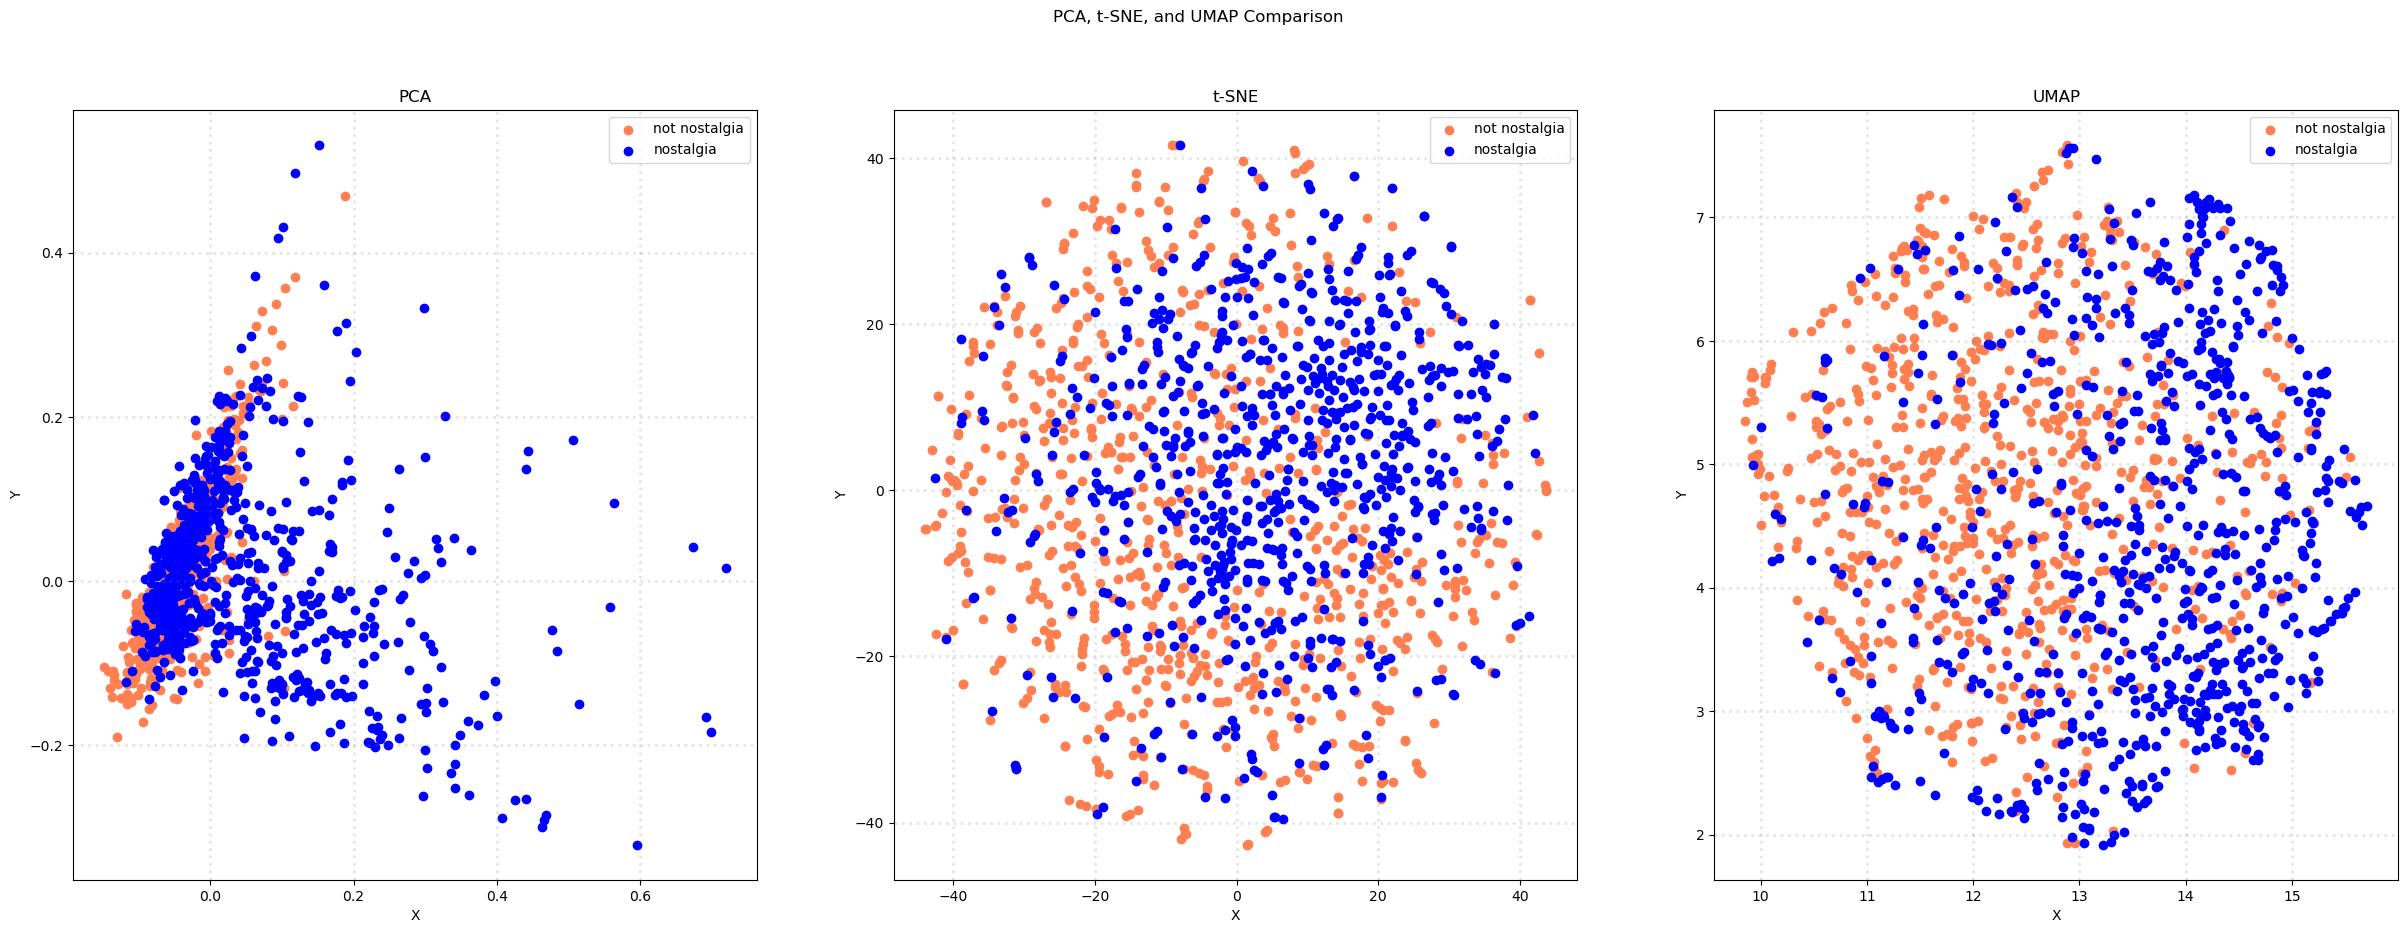

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Convert the term-document matrix to a DataFrame for easy merging
# Apply PCA, t-SNE, and UMAP to the data
X_pca_tdm = PCA(n_components=2).fit_transform(tfidf_matrix)
X_tsne_tdm = TSNE(n_components=2, init="random").fit_transform(tfidf_matrix)
X_umap_tdm = umap.UMAP(n_components=2).fit_transform(tfidf_matrix)

# Plot the results in subplots
col = ['coral', 'blue']
categories = X['category'].unique() 

fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category'] == category].T[0]
        ys = X_reduced[X['category'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_tdm, 'PCA')
plot_scatter(axes[1], X_tsne_tdm, 't-SNE')
plot_scatter(axes[2], X_umap_tdm, 'UMAP')

plt.show()

In [44]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, X['sentiment'], test_size=0.3, random_state=42)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8266666666666667

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.7653    0.9422    0.8446       225
not nostalgia     0.9249    0.7111    0.8040       225

     accuracy                         0.8267       450
    macro avg     0.8451    0.8267    0.8243       450
 weighted avg     0.8451    0.8267    0.8243       450



In [43]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['sentiment'], test_size=0.3, random_state=42)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7955555555555556

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.9404    0.6311    0.7553       225
not nostalgia     0.7224    0.9600    0.8244       225

     accuracy                         0.7956       450
    macro avg     0.8314    0.7956    0.7899       450
 weighted avg     0.8314    0.7956    0.7899       450



### 6. Concluding Remarks

結果發現原始資料的分類做得比較好，可能是增強的重要資訊到資料中，反而讓資訊增加更多雜訊。
